# **Róbert Šafár** & **Matúš Totcimak**
## 2. fáza: *Predspracovanie údajov*
#### Dataset 82
#### Podiel práce 0:0
#
#

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import re
from sklearn.model_selection import train_test_split

## Načítanie CSV súborov

In [42]:
con = pd.read_csv("dataset82/connections.csv", sep='\t')
proc = pd.read_csv("dataset82/processes.csv", sep='\t')
dev = pd.read_csv("dataset82/devices.csv", sep='\t')
prof = pd.read_csv("dataset82/profiles.csv", sep='\t')

In [43]:
pd.set_option('display.max_columns', None)

#
# **2.1 Realizácia predspracovania dát**

### Ná základe prvej fázy nebudeme pracovať s `Devices` a `Profiles`.
### `Connections` a `Processes` majú viacero záznamov pre jedno `imei`. To isté platí pre `Devices` a `Profiles`. Keďže tieto DFs dokážeme spojiť len cez `imei`, priraďovali by sme k sebe záznamy, ktoré k sebe nepatria.

#
## *A) Rozdelenie dát na trénovaciu a testovaciu množinu.*

### Pred spojením `Connections` a `Processes` odstránime duplikátne záznamy.

In [44]:
con = con.loc[~con.duplicated()].reset_index(drop=True).copy()
proc = proc.loc[~proc.duplicated()].reset_index(drop=True).copy()

### Spojenie `Connections` a `Processes`. Rovnako ako vo Fáze 1.

In [45]:
df = pd.merge(con, proc, on=['ts', 'imei', 'mwra'])

### Nový DF rozdelíme na `data` a `target`.

In [46]:
# Data
X = df.drop(columns=['mwra'])

# Target
y = df[['mwra']]

### Pomer rozdelenia zvolíme `80:20`.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, test_size=0.2)

#
## *B) Transformujte dáta na vhodný formát pre ML.*

### `ts` ?

### Overenie chýbajúcich hodnôt. Z `EDA` už vieme, že žiadne nie sú.

In [48]:
X_train.isna().sum()[X_train.isna().sum() > 0]

Series([], dtype: int64)

In [49]:
#X_train['ts'] = pd.to_datetime(X_train['ts'])

### Vymažeme atribút `imei`, pretože ho nepovažujeme za atribút, ktorý by určoval hodnotu `mwra`. Je to len identifikátor zariadení. Takisto aj `ts`.

In [50]:
X_train = X_train.drop(columns=['ts', 'imei'])

#
### *`Funkcia:`* Vykreslenie Box-plotov pre každý atribút z `df`.

In [51]:
def show_boxplots(df):
    _, ax = plt.subplots(figsize=(17, 7))
    df.boxplot(ax=ax,
                    boxprops=dict(color='#34495E'),
                    flierprops=dict(markeredgecolor='#9B59B6', markersize=5),
                    medianprops=dict(color='#3498DB', linewidth=1.5),
                    capprops=dict(color='black'),
                    whiskerprops=dict(color='black')
                    )
    ax.grid(True, linewidth=0.3)
    plt.xticks(rotation=270)
    plt.title("Boxploty atribútov X_train")
    plt.ylabel("Hodnoty")
    plt.show()

### Zobrazenie atribútov a ich outlierov pomocou `Box-plotov`.

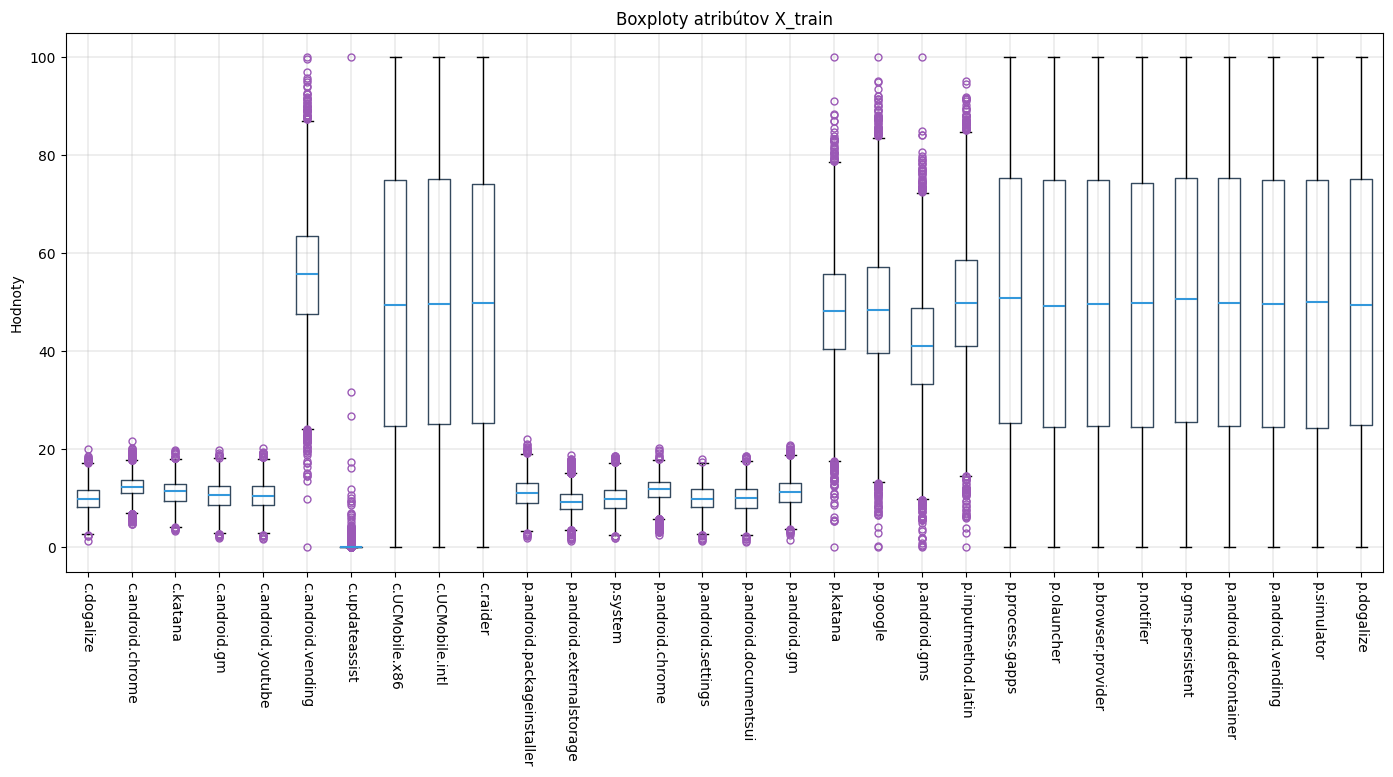

In [52]:
show_boxplots(X_train)

### *`Funckia:`* Zmena outlierov na hraničné hodnoty.

In [53]:
def change_outliers_iqr(df, exceptions):
    for column in df:
        if column in exceptions:
            continue
        
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

### Zmena outlierov pre všetky atribúty `df` okrem `df['c.updateassist']`.

In [54]:
X_train = change_outliers_iqr(X_train, ['ts', 'c.updateassist'])

### Odstránenie záznamov, kde `df['c.updateassist'] >= 5`. Rovnako ako v `EDA`.

In [55]:
X_train = X_train[X_train['c.updateassist'] < 5]

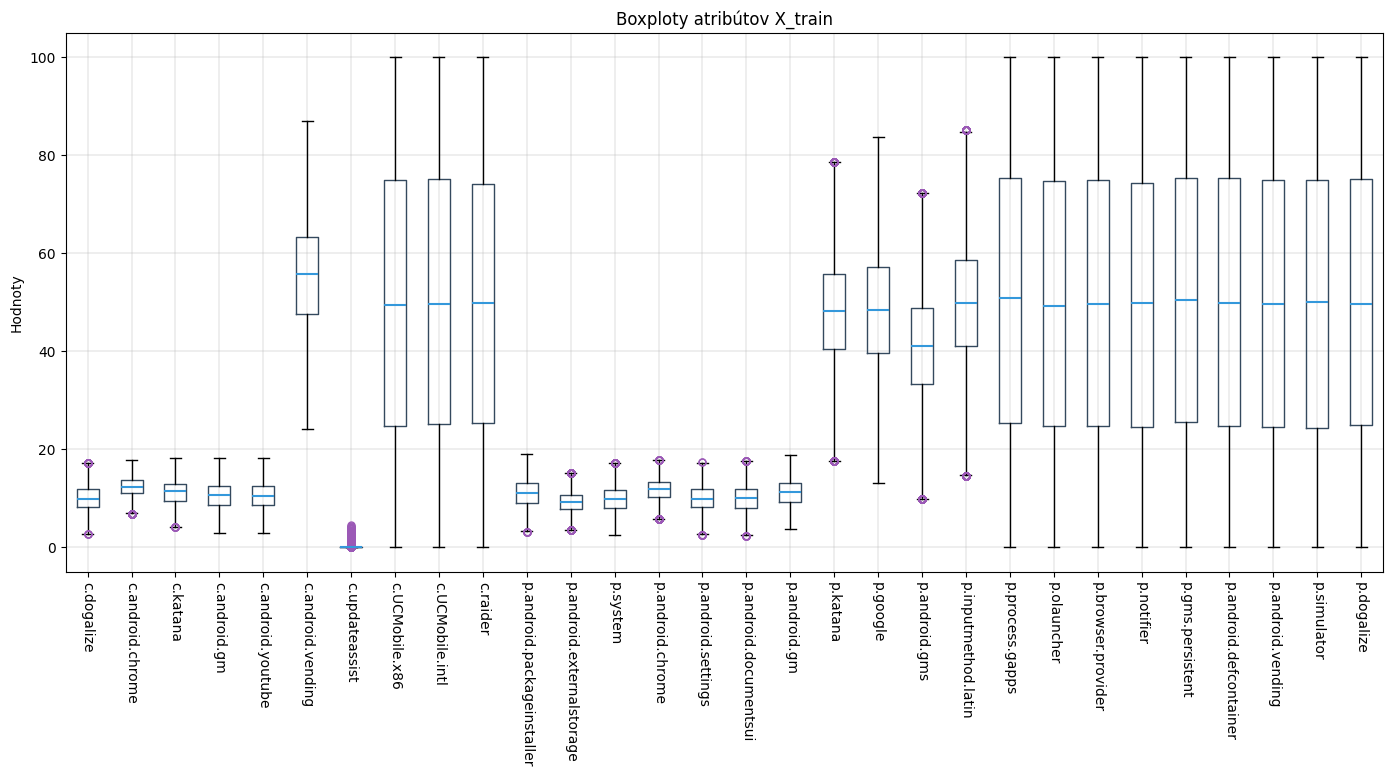

In [56]:
show_boxplots(X_train)

### Niektoré outliery zostali, pretože sa nachádzajú blízko dolnej/hornej hranice. Môžeme ich však považovať za zanedbateľné. Rovnako sme postupovali s outliermi v `EDA`.

## Mozno ukazky na OrdinalEncoder / SimpleImputer.
#

### OneHotEncoder(vsetky kategorie ako stlpce -> 0/1) | OrdinalEncoder(uviest, konkretne moznosti daneho stlpca -> S M L)

#
## *C) Transformujte atribúty dát pre strojové učenie.*

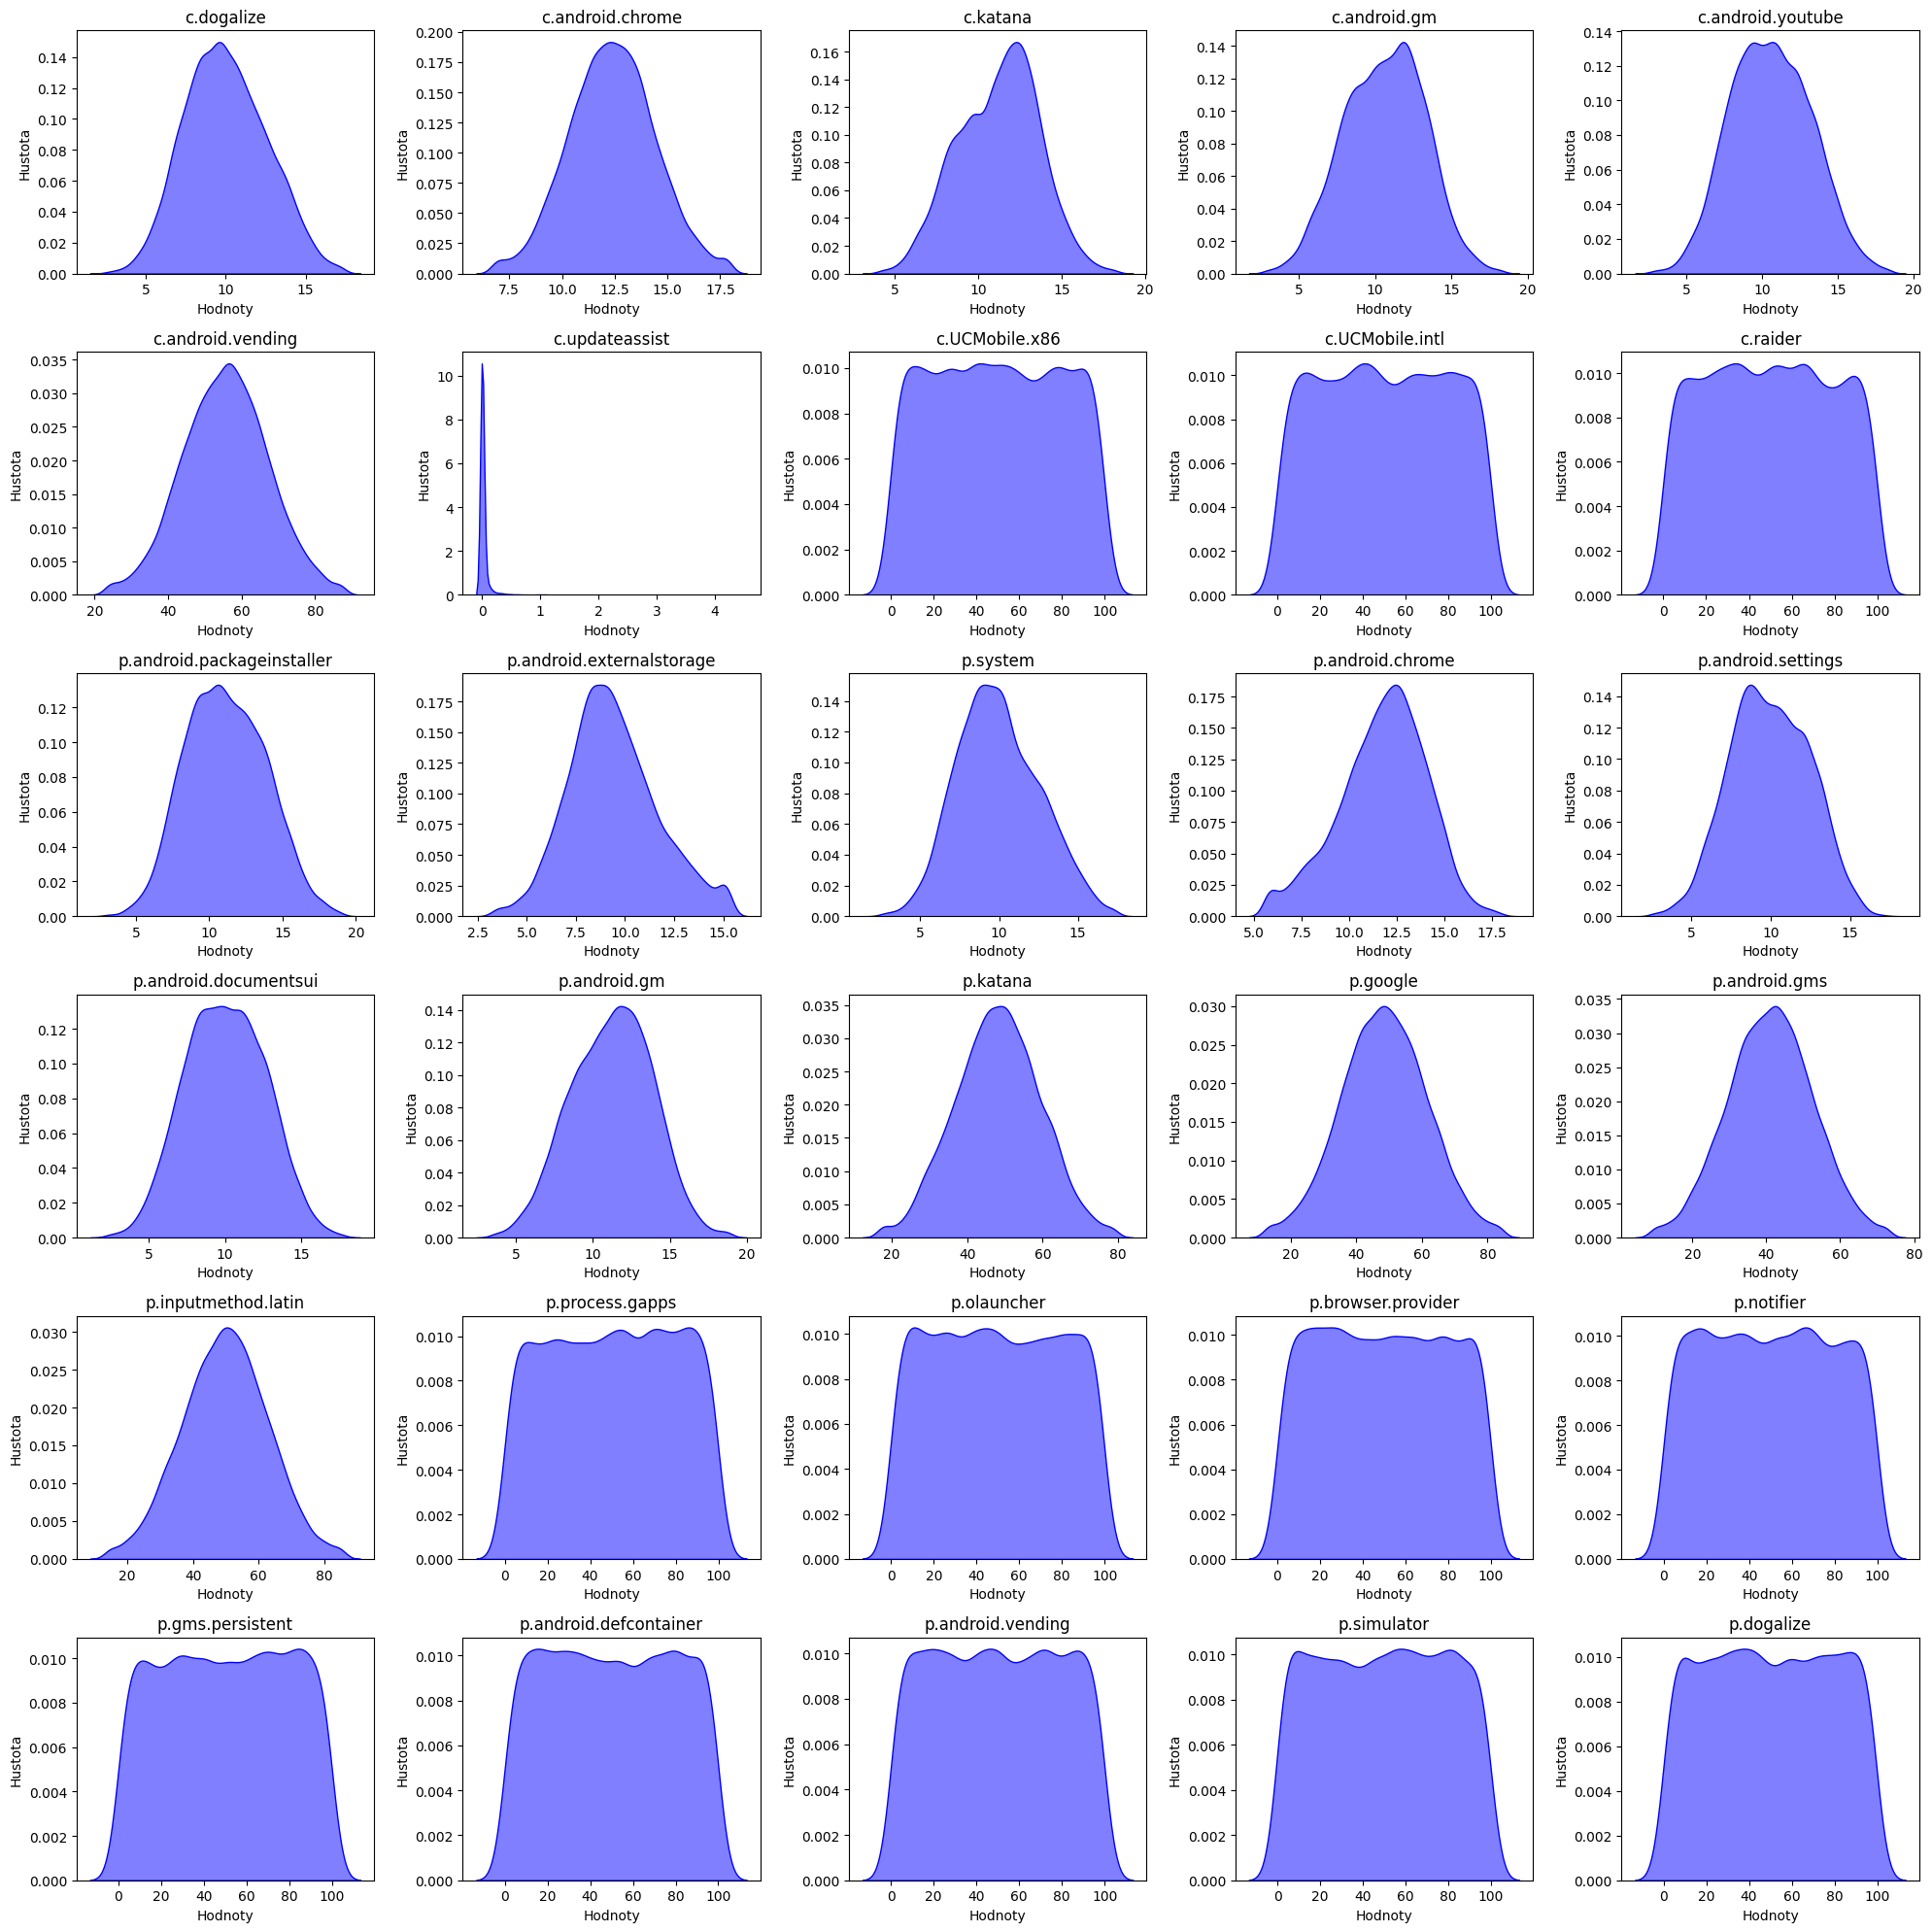

In [ ]:
plt.figure(figsize=(20, 20))

for i, column in enumerate(X_train.columns):
    plt.subplot(6, 5, i + 1)
    sns.kdeplot(X_train[column], fill=True, color='blue', alpha=0.5)
    plt.title(column)
    plt.xlabel('Hodnoty')
    plt.ylabel('Hustota')

plt.tight_layout()
plt.show()

# SCALING
- Standard: 'c.dogalize' 'c.android.vending' 'p.android.packageinstaller' 'p.system' 'p.android.documentsui' 'p.katana' 'p.android.gms'
- MinMax: 'c.android.chrome' 'c.android.youtube' 'c.updateassist' 'p.android.gm' 'p.google' 'p.inputmethod.latin'

# TRANSFORMATION
- Yeo-Johnson: 'c.android.gm' 'c.UCMobile.x86' 'c.raider' 'p.android.settings' 'p.process.gapps' 'p.browser.provider' 'p.gms.persistent' 'p.android.vending' 'p.dogalize'
- Box-Cox: 'c.katana' 'c.UCMobile.intl' 'p.android.externalstorage' 'p.android.chrome' 'p.olauncher' 'p.notifier' 'p.android.defcontainer' 'p.simulator'

In [58]:
X_train.columns

Index(['c.dogalize', 'c.android.chrome', 'c.katana', 'c.android.gm',
       'c.android.youtube', 'c.android.vending', 'c.updateassist',
       'c.UCMobile.x86', 'c.UCMobile.intl', 'c.raider',
       'p.android.packageinstaller', 'p.android.externalstorage', 'p.system',
       'p.android.chrome', 'p.android.settings', 'p.android.documentsui',
       'p.android.gm', 'p.katana', 'p.google', 'p.android.gms',
       'p.inputmethod.latin', 'p.process.gapps', 'p.olauncher',
       'p.browser.provider', 'p.notifier', 'p.gms.persistent',
       'p.android.defcontainer', 'p.android.vending', 'p.simulator',
       'p.dogalize'],
      dtype='object')

In [61]:
y_train['mwra'].value_counts()

mwra
1.0    7514
0.0    4472
Name: count, dtype: int64

### Scaling: StandardScaler(mean=0, sd=1) | MinMaxScaler(range(0,1))

### Transform: Logaritmická transformácia | 

## *D) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu.*

#
# **2.2 Výber atribútov pre strojové učenie**

## *A) Zistite, ktoré atribúty sú informatívne k predikovanej premennej.*

## *B) Zoraďte zistené atribúty v poradí podľa dôležitosti.*

## *C) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu.*

#
# **2.3 Výber atribútov pre strojové učenie**

## *A) Upravte váš kód realizujúci predspracovanie trénovacej množiny na použitie predspracovania testovacej množiny v kontexte strojového učenia.*

## *B) Využite možnosti sklearn.pipeline.*